In [1]:
import moxing as mox
import os
if not os.path.exists('galleryweights.zip'):
    mox.file.copy_parallel("obs://mindspore-ospp-yoloworldv2/galleryweights.zip", "galleryweights.zip")
    !unzip galleryweights.zip
if not os.path.exists('YOLO-WorldV2-MindSpore.zip'):
    mox.file.copy_parallel("obs://mindspore-ospp-yoloworldv2/YOLO-WorldV2-MindSpore.zip", "YOLO-WorldV2-MindSpore.zip")
    !unzip YOLO-WorldV2-MindSpore.zip
if not os.path.exists('mindnlp.zip'):
    mox.file.copy_parallel("obs://mindspore-ospp-yoloworldv2/mindnlp.zip", "mindnlp.zip")
    !unzip mindnlp.zip


INFO:root:Using MoXing-v2.1.6.879ab2f4-879ab2f4

INFO:root:Using OBS-Python-SDK-3.20.9.1


## 确认python版本

In [2]:
!python -V

Python 3.9.11


## pip安装mindspore 2.2.14

In [3]:
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/2.2.14/MindSpore/unified/x86_64/mindspore-2.2.14-cp39-cp39-linux_x86_64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


  Using cached https://ms-release.obs.cn-north-4.myhuaweicloud.com/2.2.14/MindSpore/unified/x86_64/mindspore-2.2.14-cp39-cp39-linux_x86_64.whl (743.0 MB)












You should consider upgrading via the '/home/ma-user/anaconda3/envs/python-3.9.11/bin/python -m pip install --upgrade pip' command.


## 卸载重装kiwisolver这个库

In [4]:
!pip uninstall kiwisolver -y

Found existing installation: kiwisolver 1.4.5

Uninstalling kiwisolver-1.4.5:

  Successfully uninstalled kiwisolver-1.4.5


## 安装yolow库，并且安装所有对应依赖

In [5]:
!pip install -e .

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple

Obtaining file:///home/ma-user/work/ma_share/YOLOWorldV2-AI_Gallery-Release


















     |████████████████████████████████| 1.6 MB 13.5 MB/s eta 0:00:01


























































































  Attempting uninstall: yolow

    Found existing installation: yolow 0.1

    Uninstalling yolow-0.1:

      Successfully uninstalled yolow-0.1

  Running setup.py develop for yolow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

modelarts 1.4.25 requires huaweicloudsdkcore<=3.1.58, but you have huaweicloudsdkcore 3.1.113 which is incompatible.

modelarts 1.4.25 requires lxml==5.1.0, but you have lxml 4.9.3 which is incompatible.

modelarts 1.4.25 requires matplotlib==3.5.2, but you have matplotlib 3.7.5 which is incompatible.

modelarts

## 脚本推理

In [6]:
# !python scripts/inference.py

## 导入推理所需库

In [7]:
import cv2
import supervision as sv
from mindspore.dataset.transforms.py_transforms import Compose


from yolow.data.transforms import (YOLOResize, LoadAnnotations, LoadImageFromFile, LoadText,
                                   PackDetInputs, PackDetInputs)

from yolow.model import (build_yolov8_backbone, build_yoloworld_data_preprocessor,
                         build_yoloworld_head, build_yoloworld_neck, build_yoloworld_text,
                         build_yoloworld_backbone, build_yoloworld_detector)


import mindspore as ms
import yaml

bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=2)
mask_annotator = sv.MaskAnnotator()

from mindspore.communication.management import init, get_rank, get_group_size
from mindspore import Profiler

import csv
from collections import defaultdict

from tqdm import tqdm

import matplotlib.pyplot as plt


Building prefix dict from the default dictionary ...

DEBUG:jieba:Building prefix dict from the default dictionary ...

Loading model from cache /tmp/jieba.cache

DEBUG:jieba:Loading model from cache /tmp/jieba.cache

Loading model cost 0.591 seconds.

DEBUG:jieba:Loading model cost 0.591 seconds.

Prefix dict has been built successfully.

DEBUG:jieba:Prefix dict has been built successfully.


## 初始化运行环境

In [8]:
def init_env(cfg):
    """初始化运行时环境."""
    ms.set_seed(cfg["seed"])
    # 如果device_target设置是None，利用框架自动获取device_target，否则使用设置的。
    if cfg["device_target"] != "None":
        # if cfg["device_target"] not in ["Ascend", "GPU", "CPU"]:
        #     raise ValueError(f"Invalid device_target:{cfg["device_target"]}, "
        #                      f"should be in ['None', 'Ascend', 'GPU', 'CPU']")
        ms.set_context(device_target=cfg["device_target"])

    # 配置运行模式，支持图模式和PYNATIVE模式
    # if cfg["context_mode"] not in ["graph", "pynative"]:
    #     raise ValueError(f"Invalid context_mode: {cfg["context_mode"]}, "
    #                      f"should be in ['graph', 'pynative']")
    context_mode = ms.GRAPH_MODE if cfg["context_mode"] == "graph" else ms.PYNATIVE_MODE
    ms.set_context(mode=context_mode)

    cfg["device_target"] = ms.get_context("device_target")

    # 如果是CPU上运行的话，不配置多卡环境
    if cfg["device_target"] == "CPU":
        cfg["device_id"] = 0
        cfg["device_num"] = 1
        cfg["rank_id"] = 0

    # 设置运行时使用的卡
    if hasattr(cfg, "device_id") and isinstance(cfg["device_id"], int):
        ms.set_context(device_id=cfg["device_id"])

    if cfg["device_num"] > 1:
        # init方法用于多卡的初始化，不区分Ascend和GPU，get_group_size和get_rank方法只能在init后使用
        init()
        print("run distribute!", flush=True)
        group_size = get_group_size()
        # if cfg["device_num"] != group_size:
        #     raise ValueError(f"the setting device_num: {cfg["device_num"]} not equal to the real group_size: {group_size}")
        cfg["rank_id"] = get_rank()
        ms.set_auto_parallel_context(parallel_mode=ms.ParallelMode.DATA_PARALLEL, gradients_mean=True)
        if hasattr(cfg, "all_reduce_fusion_config"):
            ms.set_auto_parallel_context(all_reduce_fusion_config=cfg.all_reduce_fusion_config)
    else:
        cfg["device_num"] = 1
        cfg["rank_id"] = 0
        print("run standalone!", flush=True)

## 标签绘制类

In [9]:
class LabelAnnotator(sv.LabelAnnotator):

    @staticmethod
    def resolve_text_background_xyxy(
        center_coordinates,
        text_wh,
        position,
    ):
        center_x, center_y = center_coordinates
        text_w, text_h = text_wh
        return center_x, center_y, center_x + text_w, center_y + text_h


label_annotator = LabelAnnotator(text_padding=4, text_scale=0.5, text_thickness=1)

def colorstr(*input):
    """
        Helper function for style logging
    """
    *args, string = input if len(input) > 1 else ("bold", input[0])
    colors = {"bold": "\033[1m"}

    return "".join(colors[x] for x in args) + f"{string}"

## 构建yolo-world model

In [10]:
def create_model(model_size, model_file):
    # We have predefined settings in `model/model_cfgs`,
    # including the default architectures for different
    # sizes of YOLO-World models.
    # You can further specify some items via model_args.
    model_args = dict(
        yoloworld_data_preprocessor=dict(),
        yolov8_backbone=dict(),
        yoloworld_text=dict(),
        yoloworld_backbone=dict(),
        yoloworld_neck=dict(),
        yoloworld_head_module=dict(),
        yoloworld_detector=dict(),
    )
    

    # build model
    data_preprocessor = build_yoloworld_data_preprocessor(model_size, args=model_args)
    ms_backbone = build_yolov8_backbone(model_size, args=model_args)
    ms_text_backbone = build_yoloworld_text(model_size, args=model_args)

    ms_yolow_backbone = build_yoloworld_backbone(model_size, ms_backbone, ms_text_backbone, args=model_args)

    ms_neck = build_yoloworld_neck(model_size, args=model_args)
    ms_head = build_yoloworld_head(model_size, args=model_args)

    ms_yoloworld_model = build_yoloworld_detector(
        model_size, ms_yolow_backbone, ms_neck, ms_head, data_preprocessor, args=model_args)

    ms_ckpt_path = model_file
    
    
    ms.load_checkpoint(ms_ckpt_path, ms_yoloworld_model)

    return ms_yoloworld_model

## 推理函数

In [11]:
def run_image(
        ms_model,
        input_image,
        max_num_boxes=100,
        score_thr=0.1,
        nms_thr=0.7,
        img_scale=(1280, 1280),
        output_image="./demo_imgs/output.png",
):
    texts = [[t.strip()] for t in class_names.split(",")] + [[" "]]

    ms_pipeline = Compose([
        LoadImageFromFile(),
        YOLOResize(scale=img_scale),
        LoadAnnotations(with_bbox=True),
        LoadText(),
        PackDetInputs(meta_keys=('img_id', 'img_path', 'ori_shape', \
                            'img_shape', 'scale_factor', 'pad_param', 'texts'))
    ])


    data_info = ms_pipeline(dict(img_id=0, img_path=input_image, texts=texts))[0]
    image = cv2.imread(input_image)

    data_batch = dict(
        inputs=[data_info["inputs"]],
        data_samples=[data_info["data_samples"]],
    )


    time_dict_lst = []

    ms_output, time_d = ms_model(data_batch)
    time_dict_lst.append(time_d)
    
    dict2csv(time_dict_lst)
    
        
    ms_output = ms_output[0]
    ms_pred_instances = ms_output['pred_instances']

    # mindspore postprocess    
    box_with_score = ms.ops.cat((ms_pred_instances.bboxes, ms_pred_instances.scores.unsqueeze(-1)), axis=1)
    output_boxes, output_idxs, selected_mask = ms.ops.NMSWithMask(nms_thr)(box_with_score)

    keep_idxs = output_idxs[selected_mask]

    new_ms_pred_instances = {
        'scores': [ms_pred_instances.scores[idx] for idx in keep_idxs if ms_pred_instances.scores[idx].float() > score_thr],
        'labels': [ms_pred_instances.labels[idx] for idx in keep_idxs if ms_pred_instances.scores[idx].float() > score_thr],
        'bboxes': [ms_pred_instances.bboxes[idx] for idx in keep_idxs if ms_pred_instances.scores[idx].float() > score_thr]
    }
    if len(new_ms_pred_instances['bboxes']):
        new_ms_pred_instances = {key: ms.ops.stack(value).asnumpy()  for key, value in new_ms_pred_instances.items()}
        ms_pred_instances = new_ms_pred_instances

        if len(ms_pred_instances['scores']) > max_num_boxes:
            indices = ms_pred_instances['scores'].float().topk(max_num_boxes)[1]
            ms_pred_instances = ms_pred_instances[indices]
        ms_output['pred_instances'] = ms_pred_instances

        if 'masks' in ms_pred_instances:
            masks = ms_pred_instances['masks']
        else:
            masks = None

        detections = sv.Detections(
            xyxy=ms_pred_instances['bboxes'], class_id=ms_pred_instances['labels'], confidence=ms_pred_instances['scores'])

        labels = [
            f"{texts[class_id][0]} {confidence:0.2f}"
            for class_id, confidence in zip(detections.class_id, detections.confidence)
        ]

        # label images
        image = bounding_box_annotator.annotate(image, detections)
        image = label_annotator.annotate(image, detections, labels=labels)
        if masks is not None:
            image = mask_annotator.annotate(image, detections)
    cv2.imwrite(output_image.replace('.png', '_ms_.png'), image)
    print(f"Results saved to {colorstr('bold', output_image.replace('.png', '_ms_.png'))}")
    
    img = image[:,:,::-1]
    plt.imshow(img)
    plt.show()

## 耗时统计

In [12]:
def dict2csv(dict_lst):
    # Step 1: Aggregate the values for each key
    aggregated_data = defaultdict(list)
    for time_dict in dict_lst:
        for key, value in time_dict.items():
            aggregated_data[key].append(value)

    # Step 2: Compute the average for each key
    average_data = {key: sum(values) / len(values) for key, values in aggregated_data.items()}

    # Step 3: Save the average data to a CSV file
    with open('average_times.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Key', 'Average Value'])
        for key, avg_value in average_data.items():
            writer.writerow([key, avg_value])

    print("Average values saved to average_times.csv")

## 推理参数设置（类别、运行环境配置文件、模型大小、模型权重文件路径）

In [13]:
# coco classes
# class_names = ("person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, "
#                "traffic light, fire hydrant, stop sign, parking meter, bench, bird, "
#                "cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, "
#                "backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, "
#                "sports ball, kite, baseball bat, baseball glove, skateboard, "
#                "surfboard, tennis racket, bottle, wine glass, cup, fork, knife, "
#                "spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, "
#                "hot dog, pizza, donut, cake, chair, couch, potted plant, bed, "
#                "dining table, toilet, tv, laptop, mouse, remote, keyboard, "
#                "cell phone, microwave, oven, toaster, sink, refrigerator, book, "
#                "clock, vase, scissors, teddy bear, hair drier, toothbrush")

env_path = "./env.yaml"
model_size = "s"
model_ckpt_path = "./galleryweights/ms-change-yolo_world_v2_s_obj365v1_goldg_pretrain-55b943ea.ckpt"

In [14]:
with open(env_path, 'r', encoding='utf-8') as f:
        config = yaml.safe_load(f)
print(config)
# 初始化运行时环境
init_env(config)

# create model
ms_model = create_model(
    model_size,  # [s/m/l/x/xl]
    model_ckpt_path)



{'seed': 1, 'device_target': 'CPU', 'context_mode': 'pynative', 'device_num': 1, 'device_id': 0}

run standalone!


The following parameters in checkpoint files are not loaded:

['logit_scale', 'text_model.embeddings.position_ids', 'vision_model.embeddings.class_embedding', 'vision_model.embeddings.position_ids', 'vision_model.embeddings.patch_embedding.weight', 'vision_model.embeddings.position_embedding.weight', 'vision_model.pre_layrnorm.weight', 'vision_model.pre_layrnorm.bias', 'vision_model.encoder.layers.0.self_attn.k_proj.weight', 'vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_model.encoder.layers.0.self_attn.v_proj.weight', 'vision_model.encoder.layers.0.self_attn.v_proj.bias', 'vision_model.encoder.layers.0.self_attn.q_proj.weight', 'vision_model.encoder.layers.0.self_attn.q_proj.bias', 'vision_model.encoder.layers.0.self_attn.out_proj.weight', 'vision_model.encoder.layers.0.self_attn.out_proj.bias', 'vision_model.encoder.layers.0.layer_norm1.weight', 'vision_model.encoder.layers.0.layer_norm1.bias', 'vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_model.encoder.laye

[WARNING] ME(7862:140099763361472,MainProcess):2024-09-18-17:01:06.542.976 [mindspore/dataset/core/validator_helpers.py:744] 'Compose' from mindspore.dataset.transforms.py_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Compose' from mindspore.dataset.transforms instead.


Average values saved to average_times.csv

Results saved to ./demo_imgs/output_ms_.png


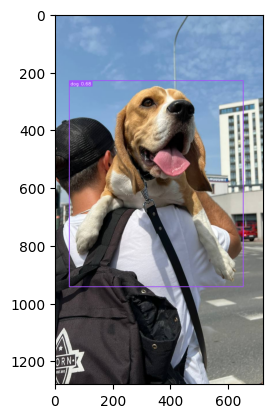

In [15]:
# 自定义检测类别
class_names = ("dog, ")
# start inference
run_image(ms_model, "./demo_imgs/dog.jpeg")

[WARNING] ME(7862:140099763361472,MainProcess):2024-09-18-17:01:13.661.532 [mindspore/dataset/core/validator_helpers.py:744] 'Compose' from mindspore.dataset.transforms.py_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Compose' from mindspore.dataset.transforms instead.


Average values saved to average_times.csv

Results saved to ./demo_imgs/output_ms_.png


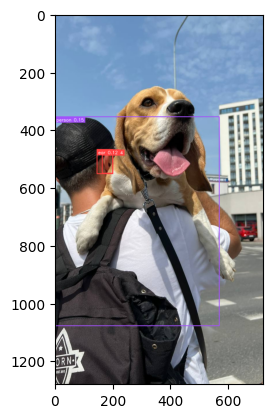

In [16]:
# 自定义检测类别
class_names = ("person, ear")
# start inference
run_image(ms_model, "./demo_imgs/dog.jpeg")